# Airbnb NYC 2019


In [1]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 16})
#mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 10

import time

In [2]:
import warnings
warnings.filterwarnings("ignore")

np.random.seed(47)

## Data Exploration
Load data and perform first exploration

In [3]:
df_airbnb = pd.read_csv('./Data/AB_NYC_2019.csv')

In [4]:
df_airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [5]:
print('Number of entries: {} \nNumber of features: {}'.format(df_airbnb.shape[0], df_airbnb.shape[1]))

Number of entries: 48895 
Number of features: 16


A first look suggests that columns such as **id**, **name** and **host_name** can be discarded from the analysis. 


In [6]:
# drop features id, host_id and host_name
df_airbnb.drop(['id', 'name', 'host_name'], axis=1, inplace=True)

Now we will look for missing data on the remaining features

In [7]:
df_airbnb.isnull().sum()

host_id                               0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

We are missing data for the following features:
* last_review --> comes from entries without any review
* reviews_per_month --> comes from entries without any review; we will replace it by 0

In [8]:
# replace NaN by 0 for column reviews per month
df_airbnb.reviews_per_month.fillna(0, inplace=True)

So far we have 13 columns, 12 of them corresponding to features and 1 corresponding to our target variable, price. 

First we will start by taking a look to the price to see its distribution and check possible outliers.

Then we will explore the features and their distributions and correlation among them. We can expect a high correlation between:
* neighbourhood_group, neighbourhood, latitude and longitude
* number_of_reviews and reviews_per_month (can also be related with last_review)
* host_id and calculated_host_listings_count

### Exploration of price

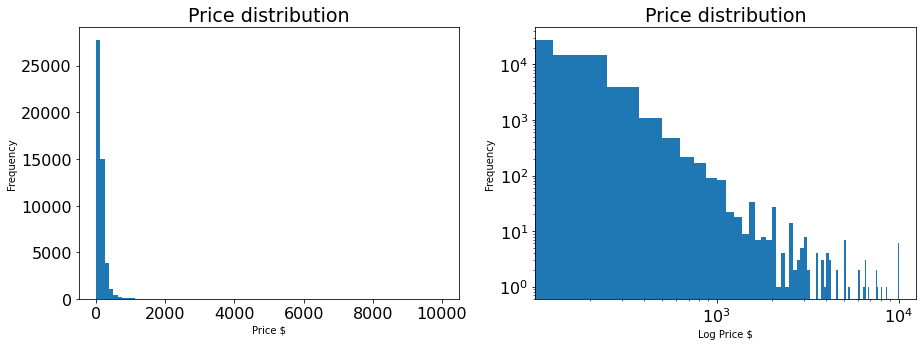

In [9]:
f, ax = plt.subplots(1, 2, figsize=(15,5))
df_airbnb['price'].plot(kind='hist', bins=80, title='Price distribution', ax=ax[0])
df_airbnb['price'].plot(kind='hist', bins=80,logx=True, logy=True, title='Price distribution', ax=ax[1])
ax[0].set_xlabel('Price $')
ax[1].set_xlabel('Log Price $')
plt.show()

In [10]:
print('Number of cases with price = $0: ',len(df_airbnb[df_airbnb.price == 0]))
print('Number of cases with price = $10k: ',len(df_airbnb[df_airbnb.price >= 9999]))

Number of cases with price = $0:  11
Number of cases with price = $10k:  6


Apartments with price \\$0 may correspond to an error or a fake offer, therefore we will drop them.
For the case of high prices, we will drop the cases with price \\$10k (or \\$9999) for the same reason. 

In [11]:
# drop cases with price 0
df_airbnb.drop(df_airbnb[df_airbnb.price == 0]. index, axis=0, inplace=True)
df_airbnb.drop(df_airbnb[df_airbnb.price >= 9999]. index, axis=0, inplace=True)

In [12]:
def print_pct_price(attribute, value):
    print('Apartments with {} over ${}: {:.2f}%'.\
          format(attribute, \
                 value, \
                 100 * len(df_airbnb[df_airbnb[attribute] > value])/len(df_airbnb)))

for p in [200, 350, 500, 1000]:
    print_pct_price('price', p)


Apartments with price over $200: 17.14%
Apartments with price over $350: 5.01%
Apartments with price over $500: 2.12%
Apartments with price over $1000: 0.48%


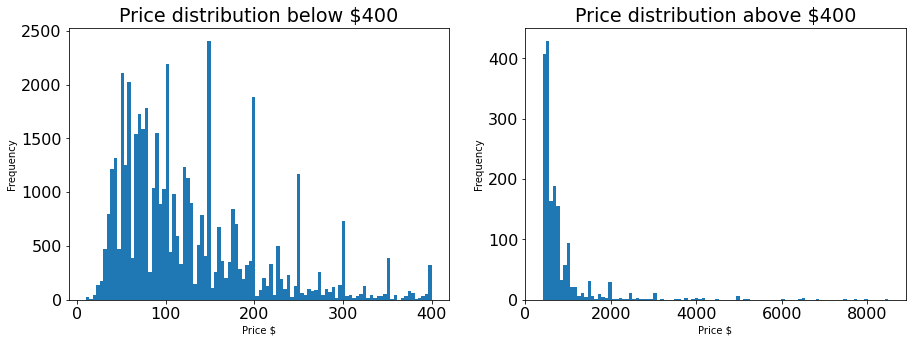

In [13]:
f, ax = plt.subplots(1, 2, figsize=(15,5))
price_max = 400
df_airbnb[df_airbnb['price'] <= price_max].price.plot(kind='hist', bins=100,\
                                                title='Price distribution below ${}'.format(price_max), ax=ax[0])
df_airbnb[df_airbnb['price'] > price_max].price.plot(kind='hist', bins=100, \
                                                     title='Price distribution above ${}'.format(price_max), ax=ax[1])
ax[0].set_xlabel('Price $')
ax[1].set_xlabel('Price $')
plt.show()


Insights: 
* The mean price is \\$153 and the median price is \\$106. This reflects large outliers that increase the mean price.
* Min price is \\$0 while max price is \\$10k. We will drop the cases with price = \\$0 or \\$10k since they may correspond to errors.
* Around 95% of the apartments have a price lower than \\$350. From these, a good amount concentrates in a range lower than \\$100. We can also observe some peaks around round prices (100, 150, etc.)
* Apartments over \\$1k represent less than 0.5\% of the cases.

### Exploration of features

The features **neighbourhood** is left out of the plot due to the large number of possible values. The feature **last_review** is left out of the plot since we cannot relate it to the date when the prices were retrieved.

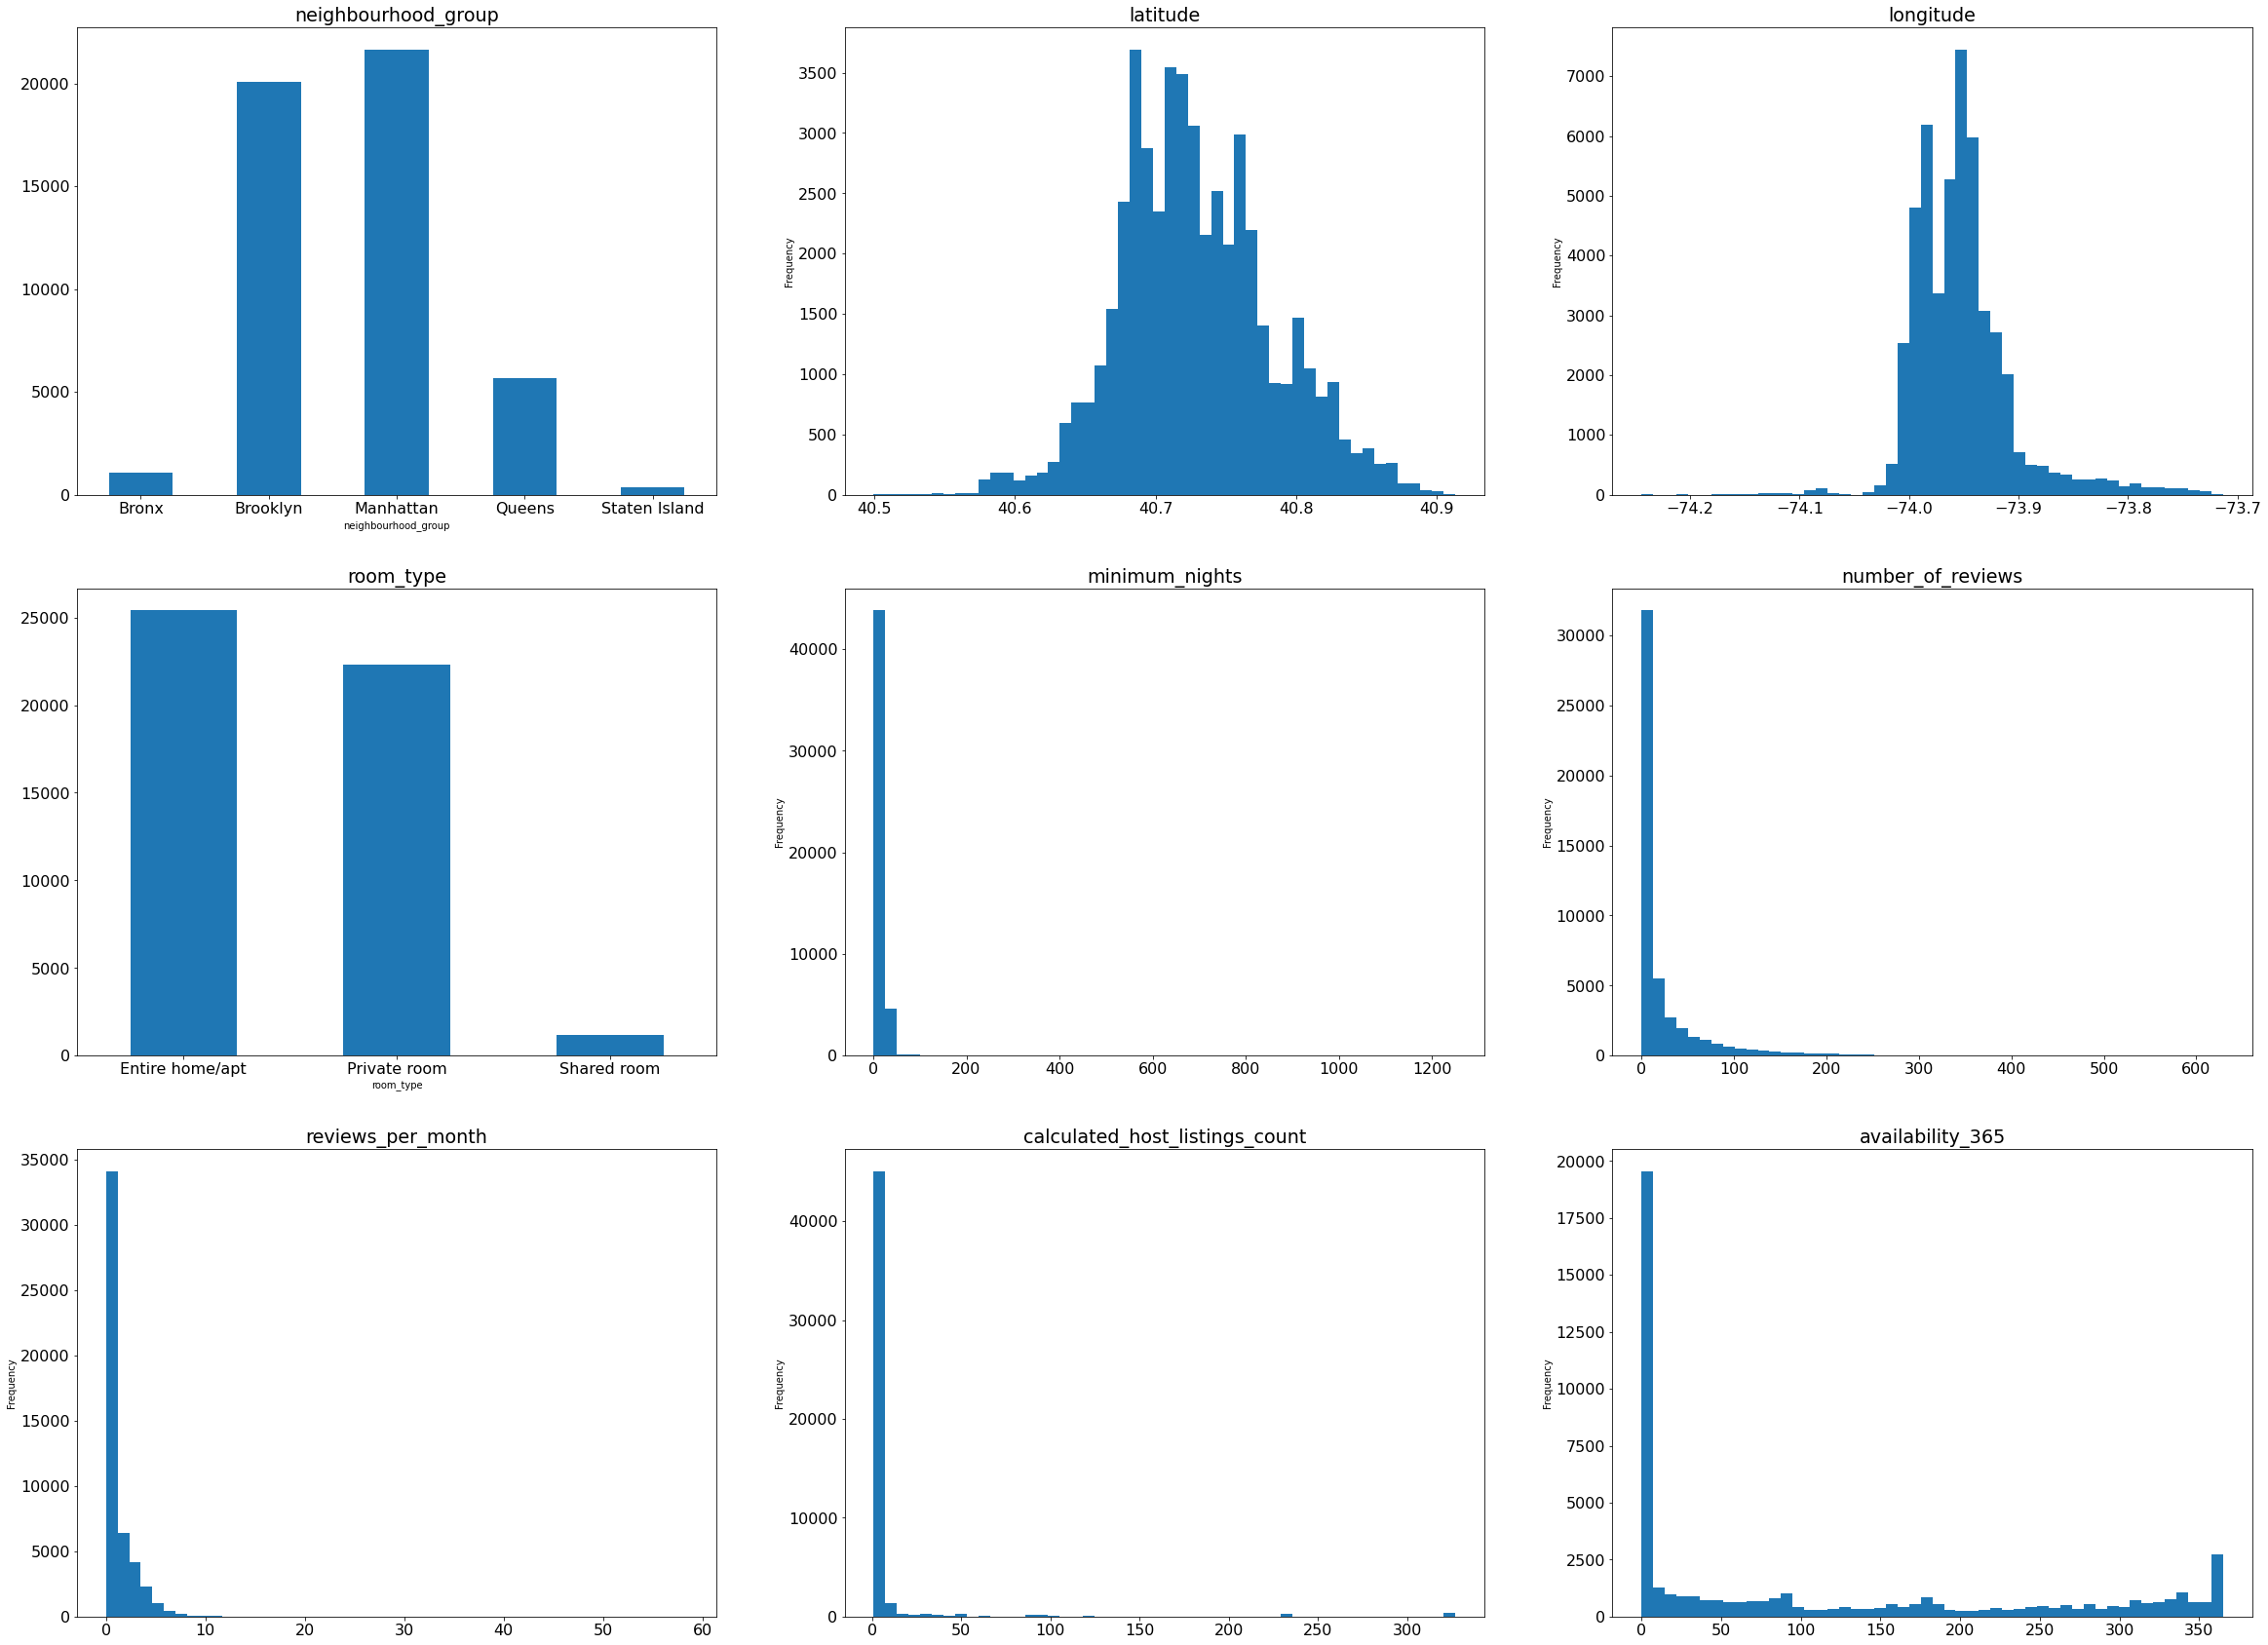

In [14]:
f, ax = plt.subplots(3,3, figsize=(40,30))
ax = ax.flatten()
for idx, col in enumerate(df_airbnb.drop(['host_id','neighbourhood', 'last_review', 'price'], axis=1).columns):
    if df_airbnb[col].dtype == object:
        df_airbnb.groupby(col).count().iloc[:,1].plot(kind='bar', ax=ax[idx], title=col)
        ax[idx].tick_params(axis='x', rotation=0)
    else:
        df_airbnb[col].plot(kind='hist', bins=50, ax=ax[idx], title=col)

Insights: 
* Neighbourhood: Brooklyn and Manhattan are the most represented ones.
* Most locations offered are entire apartments or private rooms. Shared rooms are very rare.
* Number of reviews and reviews per month seem to follow a Poisson distribution.
* Minimum nights and host listing count may offer more insights when taking logarithm of the values. 
* Availability is highly concentrated aroud 1. The rest of values seem to follow a uniform distribution with smaller probability.

#### Analysis per neighbourhood

In [15]:
df_airbnb.groupby('neighbourhood_group').agg({'neighbourhood':['count','nunique'], 
                                              'price':['min', 'mean', 'median', 'max'],
                                             'number_of_reviews':['min', 'mean', 'median', 'max']})

neighbourhood         price                           \
                            count nunique   min        mean median   max   
neighbourhood_group                                                        
Bronx                        1090      48    10   87.577064     65  2500   
Brooklyn                    20094      47    10  123.947447     90  8000   
Manhattan                   21656      32    10  195.074344    150  8500   
Queens                       5665      51    10   97.769991     75  2600   
Staten Island                 373      43    13  114.812332     75  5000   

                    number_of_reviews                         
                                  min       mean median  max  
neighbourhood_group                                           
Bronx                               0  25.977982      9  321  
Brooklyn                            0  24.198617      6  488  
Manhattan                           0  20.990118      4  607  
Queens                              0  27.704854      7  629  
Staten Island                       0  30.941019     12  333

If we analyse by neighbourhood, we can highlight:
* Manhattan is the one grouping fewer neighbourhoods with around 60% of the neighbourhoods that Queens groups (which is the one with the largest value).
* In terms of price, they all have almost the same minimum price. Nevertheless, Manhattan shows a median price that is almost 3 times the median of the lowest price (Bronx). The maximum price at Bronx is 25% of the maximum at Manhattan, Brooklyn and Staten Island. 
* In terms of number of reviews, the median is much lower than the mean in all cases, showing the presence of large sporadic numbers and a great number of low values.

In [16]:
def plot_price_dist(col_name):
    f, ax = plt.subplots(1,2, figsize=(20,5))
    ax = ax.flatten()

    sns.violinplot(data=df_airbnb[df_airbnb.price < 350], x=col_name, y='price', ax=ax[0])
    sns.violinplot(data=df_airbnb, x=col_name, y='price', ax=ax[1])
    ax[0].set_title('Price (up to $350) vs {}'.format(col_name))
    ax[1].set_title('Price vs {}'.format(col_name))
    
    plt.show()

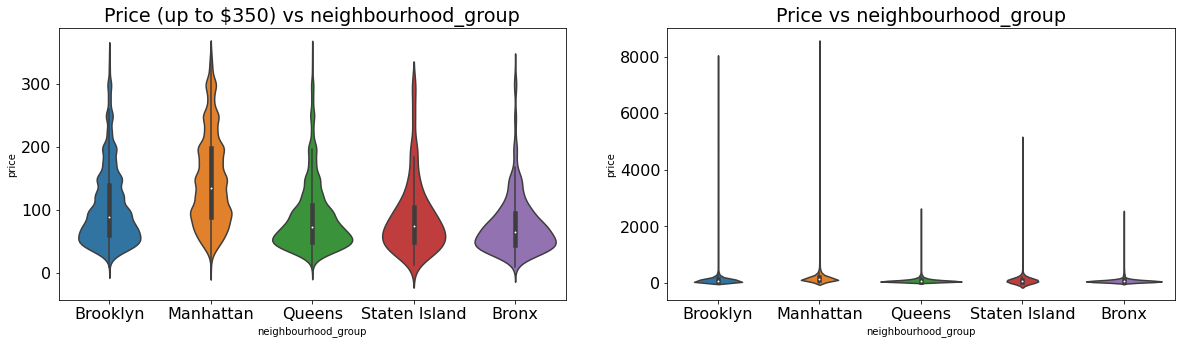

In [17]:
plot_price_dist('neighbourhood_group')

#### Analysis type of room

In [18]:
df_airbnb.groupby('room_type').agg({'price':['min', 'mean', 'median', 'max'],
                                    'number_of_reviews':['min', 'mean', 'median', 'max']})

price                          number_of_reviews             \
                  min        mean median   max               min       mean   
room_type                                                                     
Entire home/apt    10  210.269732    160  8500                 0  22.847459   
Private room       10   88.921047     70  7500                 0  24.105883   
Shared room        10   70.248705     45  1800                 0  16.622625   

                             
                median  max  
room_type                    
Entire home/apt      5  488  
Private room         5  629  
Shared room          4  454

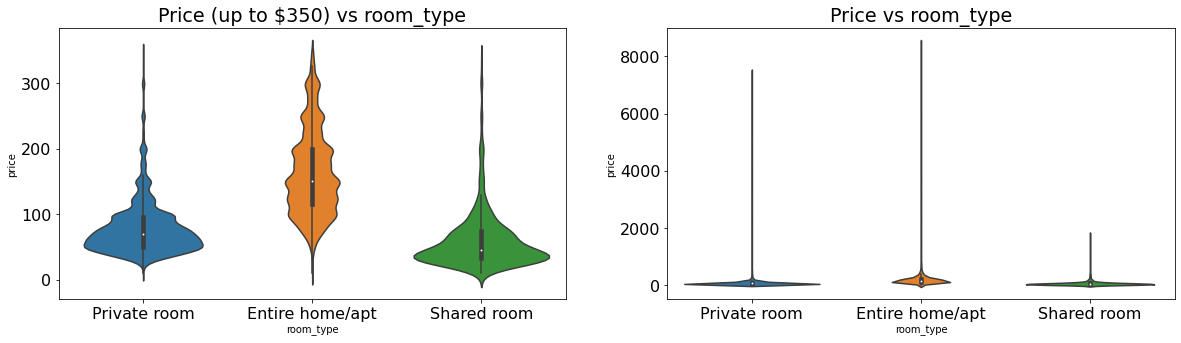

In [19]:
plot_price_dist('room_type')

From the type of room, we can highlight:
* Private and Share rooms have a similar mean price but private rooms can increase to much higher prices ( \\$10k vs \\$1.8k) 

#### Analysis reviews
The columns **last review** does not offer us much data since this value is static and we cannot relate it to the current date (the data has not been updated and we don't know the day when it was generated). Therefore, we will not consider it. 

We expect a high correlation between **number of reviews** and **reviews per month**

In [20]:
df_airbnb.drop(['last_review'], axis=1, inplace=True)
df_airbnb.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


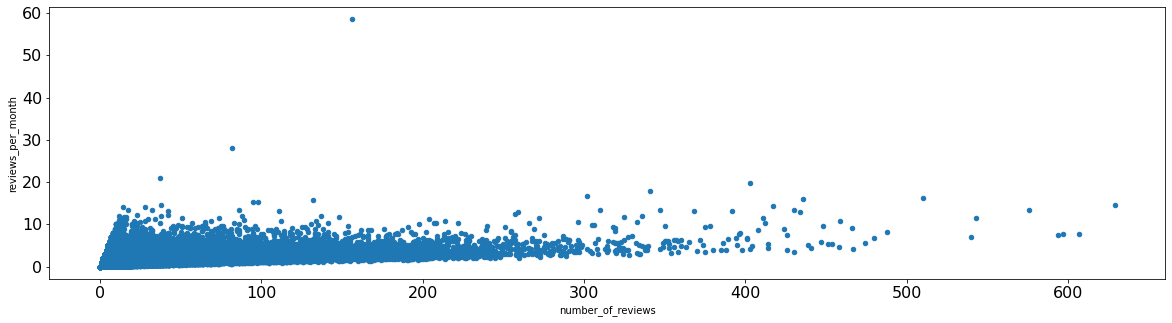

In [21]:
f, ax = plt.subplots(figsize=(20,5))
df_airbnb.plot(kind='scatter', x='number_of_reviews', y='reviews_per_month', ax=ax)
plt.show()

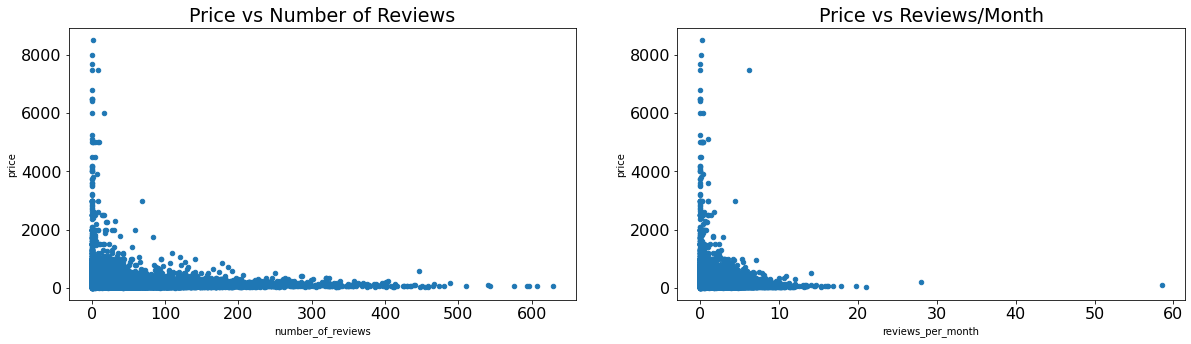

In [22]:
f, ax = plt.subplots(1,2,figsize=(20,5))
df_airbnb.plot(kind='scatter', x='number_of_reviews', y='price', \
               ax=ax[0], title='Price vs Number of Reviews')
df_airbnb.plot(kind='scatter', x='reviews_per_month', y='price', \
               ax=ax[1], title='Price vs Reviews/Month')

plt.show()

Insights from reviews:
* Number of reviews and reviews per month are correlated although less than expected (see [Correlation between features](####Correlation-between-features-and-encoding-of-categorical-variables) ). The relation is bounded.

* The relation with price shows an exponential law. 

#### Correlation between features and encoding of categorical variables

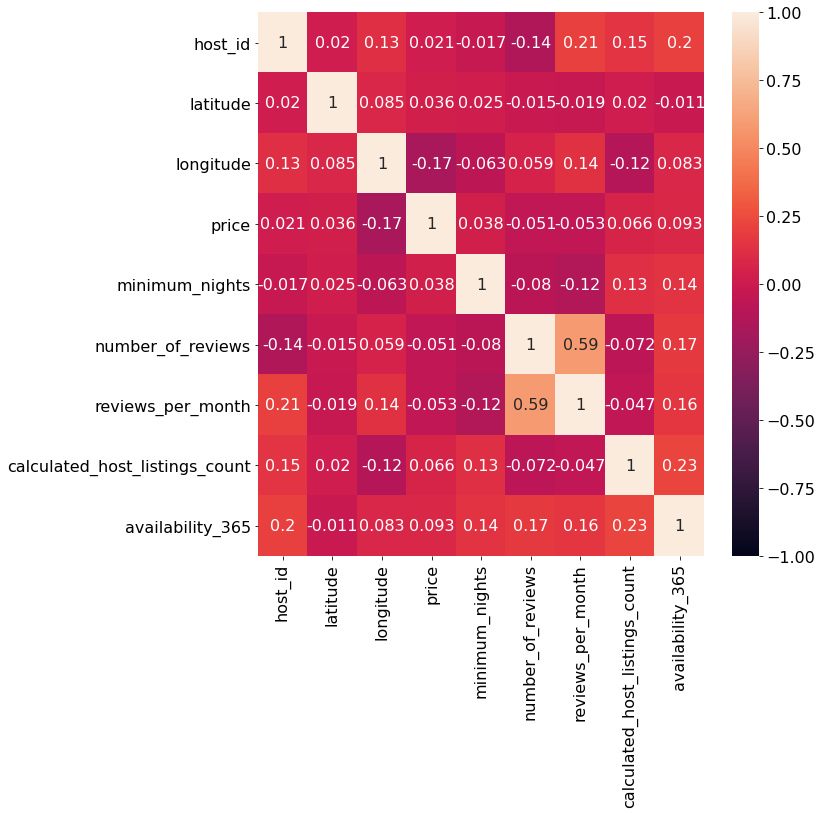

In [23]:
features = df_airbnb.drop(['neighbourhood_group', 'neighbourhood', 'room_type'], axis=1).columns
corr = np.corrcoef(df_airbnb[features].transpose()).round(decimals=3)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, ax=ax, \
            xticklabels=features, yticklabels=features)
plt.show()

**Insights from the plot:**

- Longitude (related to neighbourhood) is the most correlated feature.
- Host_id is the least correlated feature. Although we could have first thought that the presence of hosts with a large amount of facilities could help to predict the price for those apartments sharing owner, its contribution is very small to the overall set of observations. 

In general, the numerical features explored don't seem to be highly correlated with the target variable.

In [24]:
# drop neighbourhood prioritizing neighbourhood group
df_airbnb.drop(['neighbourhood'], axis=1, inplace=True)

# transform categorical variables to 1-hot encoding
df_airbnb_encoded = pd.get_dummies(df_airbnb)

In [25]:
df_airbnb_encoded.head()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,2787,40.64749,-73.97237,149,1,9,0.21,6,365,0,1,0,0,0,0,1,0
1,2845,40.75362,-73.98377,225,1,45,0.38,2,355,0,0,1,0,0,1,0,0
2,4632,40.80902,-73.94190,150,3,0,0.00,1,365,0,0,1,0,0,0,1,0
3,4869,40.68514,-73.95976,89,1,270,4.64,1,194,0,1,0,0,0,1,0,0
4,7192,40.79851,-73.94399,80,10,9,0.10,1,0,0,0,1,0,0,1,0,0


## Price Prediction:

* Create train and test set
* Standardize features
* For different models:
    - Train, tune hyperparameters, evaluate performance


In [26]:
# use data up to 95th percentile. Discard higher cases
price_outliers = 350

In [27]:
df_outliers = df_airbnb_encoded.drop(df_airbnb_encoded[df_airbnb_encoded['price'] > price_outliers].index, axis=0)
X, y = df_outliers.drop(['price'], axis=1), df_outliers.price

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# scale features
# mask one-hot encoded variables to avoid their standarization
mask_dummy_vars = [x<8 for x in range(X_train.shape[1])]
scale = StandardScaler().fit(X_train.values[:,mask_dummy_vars])
X_train_transformed = scale.transform(X_train.values[:,mask_dummy_vars])
X_test_transformed = scale.transform(X_test.values[:,mask_dummy_vars])

X_train_transformed = np.hstack([X_train_transformed, X_train.values[:,8:]])
X_test_transformed = np.hstack([X_test_transformed, X_test.values[:,8:]])


# scale price
scale_price = StandardScaler().fit(y_train.values.reshape(-1,1))
y_train_transformed = scale_price.transform(y_train.values.reshape(-1,1))
y_test_transformed = scale_price.transform(y_test.values.reshape(-1,1))

assert X_train_transformed.shape[1] == X_train.shape[1]

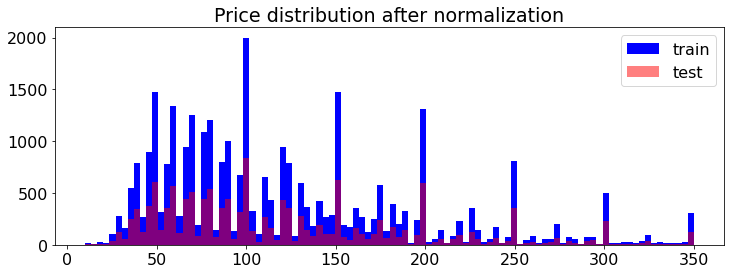

In [28]:
plt.figure(figsize=(12,4))
plt.hist(y_train, bins=100, color='b', label='train')
plt.hist(y_test, bins=100, color='r', alpha=0.5, label='test')
plt.title('Price distribution after normalization')
plt.legend()
plt.show()

### Define metrics and functions

We will evaluate: 
* RMSE: it is the metric used to train the different models. 
* MAE: used to compare models removing possible influence of outliers
* $R^2$: points out how much variance of the varible price can be predicted by the model ($R^2 = \frac{\sum_i (\widehat{y} - \overline{y})^2}{\sum_i (y_i - \overline{y})^2}$)

In [29]:
def get_score(y_pred, y_true):
    print('RMSE: {:.4f}'.format(mean_squared_error(y_true, y_pred, squared=False)))
    print('MAE : {:.4f}'.format(mean_absolute_error(y_true, y_pred)))
    print('R2  : {:.4f}'.format(r2_score(y_true, y_pred)))


In [30]:
def fit_predict_cv(model, X_train, y_train, params, cv=5):
    grid = GridSearchCV(estimator=model, param_grid=params, cv=cv)
    grid.fit(X_train, y_train)
    return grid

In [31]:
def fit_predict_best(model, X_train, y_train, X_test, y_test):
    t = time.time()
    model.fit(X_train, y_train)
    print('Training time {:.2f}s'.format(time.time() - t))

    t = time.time()
    y_pred = model.predict(X_test)
    print('Inference time {:.2f}s'.format(time.time() - t))

    get_score(y_pred, y_test)
    return y_pred

#### Model 1. Ridge Regression

- Hyper-parameters to fit: regularization term
- Pros: Simple, fast to train
- Cons: Very limited modeling capacity

In [32]:
params1 = {'alpha': np.logspace(-3, 3, 20)}
model1 = Ridge()

# hyperparameter tunning through cross-validation
grid1 = fit_predict_cv(model1, X_train_transformed, y_train_transformed, params1, cv=5)
print('Best pameters: ', grid1.best_params_)

# define best model
model1_best = Ridge(alpha=grid1.best_params_['alpha'])
# train and predict 
y_pred1 = fit_predict_best(model1_best, X_train_transformed, y_train_transformed, X_test_transformed, y_test_transformed)

Best pameters:  {'alpha': 1.438449888287663}
Training time 0.00s
Inference time 0.00s
RMSE: 0.7242
MAE : 0.5286
R2  : 0.4702


#### Model 2. Elastic Net

- Hyper-parameters to fit: regularization term, l1 ratio (regularization as l2 or l1 norm penalty)
- Pros: Simple, fast to train
- Cons: Very limited modeling capacity

In [33]:
params2 = {'alpha':np.logspace(-2, 2, 10), 'l1_ratio':np.linspace(1e-2, 1, 10)}

model2 = ElasticNet(max_iter=100)
grid2 = fit_predict_cv(model2, X_train_transformed, y_train_transformed, params2, cv=5)
print('Best pameters: ', grid2.best_params_)

model2_best = ElasticNet(alpha=grid2.best_params_['alpha'], \
                        l1_ratio=grid2.best_params_['l1_ratio'])

y_pred2 = fit_predict_best(model2_best, X_train_transformed, y_train_transformed, X_test_transformed, y_test_transformed)

Best pameters:  {'alpha': 0.01, 'l1_ratio': 0.01}
Training time 0.01s
Inference time 0.00s
RMSE: 0.7267
MAE : 0.5311
R2  : 0.4665


#### Model 3. Random Forest Regressor

- Hyper-parameters to fit: maximum depth of decision trees, number of trees. Other parameters that could be explored are min_samples_split or min_samples_leaf. Max_features (features subsampled when creating a new decision tree) is left to the default parameter (all of them) since subsampling could lead to subsets with partial dummy variables that together encode a categorical variable.
- Pros: Ensamble method, reduces overfitting. Large modeling flexibility
- Cons: Slower to train

**Random Forest default parameters**

In [34]:
y_pred3_default = fit_predict_best(RandomForestRegressor(), X_train_transformed, y_train_transformed, X_test_transformed, y_test_transformed)

Training time 13.78s
Inference time 0.29s
RMSE: 0.6549
MAE : 0.4610
R2  : 0.5667


**Random Forest tunned hyperparameters**

In [35]:
params3 = {'max_depth': range(5,12,2), 'n_estimators': (50, 100, 500)}

model3 = RandomForestRegressor()
grid3 = fit_predict_cv(model3, X_train_transformed, y_train_transformed, params3, cv=5)

print('Best pameters: ', grid3.best_params_)
model3_best = RandomForestRegressor(max_depth=grid3.best_params_["max_depth"], \
                                    n_estimators=grid3.best_params_["n_estimators"],
                                    random_state=False, verbose=False)

y_pred3 = fit_predict_best(model3_best, X_train_transformed, y_train_transformed, X_test_transformed, y_test_transformed)

Best pameters:  {'max_depth': 11, 'n_estimators': 500}
Training time 39.22s
Inference time 0.49s
RMSE: 0.6495
MAE : 0.4570
R2  : 0.5737


#### Model 4. MLP

- Hyper-parameters to fit: number of hidden layers, size of hidden layers, regularization parameter (l2-norm), learning rate (possible usage of other optimizers - adaptative methods-), maximum number of iterations. Activation function of hidden layers is set to ReLU given the nature of the problem.
- Pros: Large modeling flexibility
- Cons: Slower to train, difficult interpretability

**MLP default hyperparameters**

In [36]:
y_pred4_default = fit_predict_best(MLPRegressor(), X_train_transformed, y_train_transformed, X_test_transformed, y_test_transformed)

Training time 15.04s
Inference time 0.02s
RMSE: 0.6666
MAE : 0.4792
R2  : 0.5510


**MLP tunned hyperparameters**

In [37]:
#(10,10,10) -> 3 hidden layers of size 10
# default solver -> Adam
params4 = [{  
    'hidden_layer_sizes': [(100,), (50,50), (50,50,50)], 
    'activation': ['relu'], 
    'alpha':[1e-2], 
    'learning_rate_init':[1e-3, 1e-4], 
    'max_iter':[100],
    'validation_fraction':[0.2],
    'solver':['sgd']
}]

 

model4 = MLPRegressor(verbose=False)
grid4 = fit_predict_cv(model4, X_train_transformed, y_train_transformed, params4, cv=5)
print('Best pameters: ', grid4.best_params_)

model4_best = MLPRegressor(
    hidden_layer_sizes=grid4.best_params_['hidden_layer_sizes'],\
    activation='relu', alpha=grid4.best_params_['alpha'],\
    learning_rate_init=grid4.best_params_['learning_rate_init'],\
    max_iter=grid4.best_params_['max_iter'],
    solver='sgd')

y_pred4 = fit_predict_best(model4_best, X_train_transformed, y_train_transformed, X_test_transformed, y_test_transformed)

Best pameters:  {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'sgd', 'validation_fraction': 0.2}
Training time 22.48s
Inference time 0.04s
RMSE: 0.6720
MAE : 0.4790
R2  : 0.5438


**Comment results:**

4 different models have been trained to predict prices of Airbnb facilities. Among them, the best results are achieved with **Model 3: Random Forest**. This model achieves both lower RMSE and MAE and higher $R^2$. The second best model in terms of deviation of the prediction from the ground truth is **Model 4: Multilayer Perceptron**. This model achieves lower $R^2$ but at the same time requires less than 60% of the training time required by Model 3. 

For Model 3, tunning hyperparameters results in an improvement of the results. On the other hand, for Model 4 this improvement doesn't happen. Exploring deeper networks or layers with larger number of neurons could improve these results.

Finally, both first models have very similar performance and worse than the two more complex models. From **Model 2: Elastic Net** we can see from the best parameters found through grid search and cross validation that **L2-norm** penalty is much more effective than **L1-norm**, reason why both models (Ridge Regression and Elastic Net) have almost the same results since they work with very similar parameters.

**Other details that could improve results**

The column **name** could be used to incorporate some more features (keywords appearing in the name). We could incorporate binary features showing the presence of a word in the name field. 

Other features that could help improve the predictions are: number of rooms/ capacity, services (wifi, AC, etc.) or user's evaluation (average grade). 

### Feature Importance. Contribution of neighbourhood

To measure the contribution of the neighbourhood variable we will fit a model (Random Forest with default hyper-parameters) without information of the location (latitude, longitude and neighbourhood) and measure the difference in the $R^2$ score.

In [38]:
X_train_wo_neigh = np.delete(X_train_transformed, [1,2] + list(range(8,13)), 1)
X_test_wo_neigh = np.delete(X_test_transformed, [1,2] + list(range(8,13)), 1)

y_pred3_default_wo_neigh = fit_predict_best(\
                            RandomForestRegressor(), \
                            X_train_wo_neigh, y_train_transformed, X_test_wo_neigh, y_test_transformed)

Training time 10.17s
Inference time 0.30s
RMSE: 0.7728
MAE : 0.5611
R2  : 0.3967


The $R^2$ score drops by 0.1704, indicating that the location contributes around 17\% of the variability of the price. 

The importance of the location is also highlighted thorugh the [correlation coefficients](####Correlation-between-features-and-encoding-of-categorical-variables) where **longitude** appears to be the numerical feature with largest correlation with the price.